# Decomposing image into sum of basis images using matching pursuit (MP) algorithm

In [1]:
%matplotlib inline

In [2]:
import h5py
import dpmeans
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.util import img_as_float, img_as_uint
from scipy import ndimage
from scipy.stats import multivariate_normal

### Parameters

In [3]:
# Path to file containing Zimmer data
IN_FPATH = '/home/mn2822/Desktop/WormTracking/data/zimmer/mCherry_v00065-01581.hdf5'

# Relative threshold applied to image
THRESHOLD_REL = 0.15

# Minimum number of pixels for component to be considered
CELL_MIN_SIZE = 50

### Load Zimmer data

In [4]:
# Index of frame to use
t_frame = 500

with h5py.File(IN_FPATH, 'r') as f:
    dset = f.get('mCherry')
    frame = dset[t_frame, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Select section of frame for test image

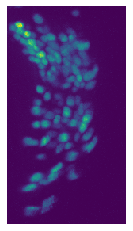

In [5]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

### TODO:

1. Create weight function
2. Implement single step of MP procedure
3. Write loop

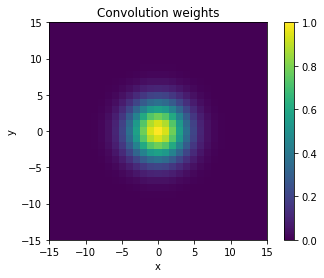

In [9]:
wx = 15
wy = 15
wz = 5
xg, yg, zg = np.mgrid[-wx:wx+1, -wy:wy+1, -wz:wz+1]
weight_grid = np.stack((xg, yg, zg), axis=-1)

mean = np.array([0, 0, 0]) 
cov = np.diag([8.0, 8.0, 1.5])
weights_nn = multivariate_normal.pdf(weight_grid, mean=mean, cov=cov)
weights = weights_nn / np.max(weights_nn)

plt.imshow(np.max(weights, 2).T, origin='lower', extent=[-15, 15, -15, 15])
plt.title('Convolution weights')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar();

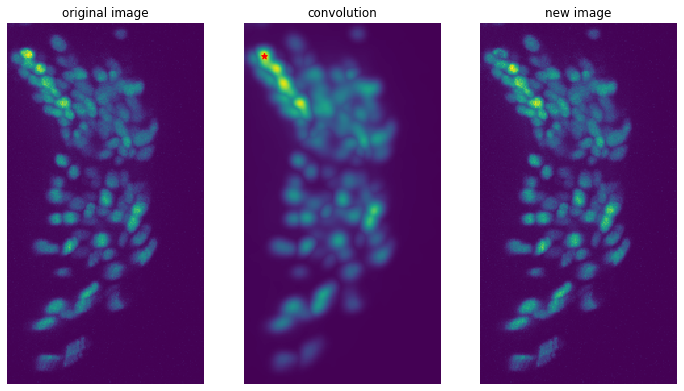

In [10]:
img_cp = np.copy(img)
conv = np.zeros(img.shape)

ndimage.filters.convolve(img, weights, output=conv)
max_pt = np.unravel_index(np.argmax(conv), conv.shape)
pix_val = img[max_pt]

x_min = max_pt[0] - wx
x_max = max_pt[0] + wx + 1
y_min = max_pt[1] - wy
y_max = max_pt[1] + wy + 1
z_min = max_pt[2] - wz
z_max = max_pt[2] + wz + 1
img_cp[x_min:x_max, y_min:y_max, z_min:z_max] = img_cp[x_min:x_max, y_min:y_max, z_min:z_max] - (weights * pix_val)

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(np.max(img, 2).T);
plt.axis('off');
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(conv, 2).T)
plt.axis('off')
plt.title('convolution');
plt.scatter(max_pt[0], max_pt[1], marker='*', color='red')

plt.subplot(133)
plt.imshow(np.max(img_cp, 2).T)
plt.axis('off')
plt.title('new image');

In [ ]:
def matching_pursuit(img, weights, n_iter):
    
    w_shape = np.asarray(weights.shape)
    assert(all((w_shape % 2) == 0))
    w_size = (w_shape - 1) / 2
    wx = np.arange(-w_size[0], w_size[0] + 1)
    wy = np.arange(-w_size[1], w_size[1] + 1)
    wz = np.arange(-w_size[2], w_size[2] + 1)
    
    img_cp = np.copy(img)
    conv = np.zeros(img.shape)

    for i in range(n_iter):
        
        ndimage.filters.convolve(img, weights, output=conv)
        max_pt = np.unravel_index(np.argmax(conv), conv.shape)
        pix_val = img[max_pt]
        
        x_idx = wx + max_pt[0]
        y_idx = wy + max_pt[1]
        z_idx = wz + max_pt[2]

        img_cp[x_idx, x_idx, z_idx] = img_cp[x_idx, y_idx, z_idx] - (weights * pix_val)
    